# Identify Dog breed using deep learning

Re-implement this project: https://github.com/besson/ds-capstone-project/tree/master/dog-project using fast.ai
It covers:

1. Download dog images
2. Create ImageDataLoader; the training and validation datasets
3. Set-up the Network architecture based on Resnet34
4. Apply transfer learning

In [1]:
from fastbook import *

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## 1. Download images

In [2]:
# Set path for loading the images from
url = "https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip"
path = untar_data(url)/'train'

### where are the files saved?

In [3]:
fastai_cfg().data

'/storage/data'

In [4]:
!ls /storage/data/dogImages/

train  valid


In [5]:
!ls /storage/data/dogImages/train/056.Dachshund/

Dachshund_03922.jpg  Dachshund_03948.jpg  Dachshund_03975.jpg
Dachshund_03923.jpg  Dachshund_03949.jpg  Dachshund_03976.jpg
Dachshund_03924.jpg  Dachshund_03950.jpg  Dachshund_03977.jpg
Dachshund_03925.jpg  Dachshund_03951.jpg  Dachshund_03978.jpg
Dachshund_03927.jpg  Dachshund_03952.jpg  Dachshund_03979.jpg
Dachshund_03928.jpg  Dachshund_03954.jpg  Dachshund_03980.jpg
Dachshund_03930.jpg  Dachshund_03955.jpg  Dachshund_03982.jpg
Dachshund_03931.jpg  Dachshund_03956.jpg  Dachshund_03983.jpg
Dachshund_03932.jpg  Dachshund_03957.jpg  Dachshund_03984.jpg
Dachshund_03933.jpg  Dachshund_03958.jpg  Dachshund_03986.jpg
Dachshund_03934.jpg  Dachshund_03959.jpg  Dachshund_03988.jpg
Dachshund_03935.jpg  Dachshund_03961.jpg  Dachshund_03989.jpg
Dachshund_03937.jpg  Dachshund_03962.jpg  Dachshund_03990.jpg
Dachshund_03938.jpg  Dachshund_03963.jpg  Dachshund_03992.jpg
Dachshund_03939.jpg  Dachshund_03964.jpg  Dachshund_03993.jpg
Dachshund_03940.jpg  Dachshund_03965.jpg  Dachshund_03994.jpg
Dachshun

## 2. Create datasets

How to include only train and valid? The code below didn't work as it tries to find files under /test

```python
pattern = "/storage/data/dogImages/(train|valid)/?\d+\..*/?\w+.*\d+.jpg$"

dls = ImageDataLoaders.from_path_re(
                            path=path,
                            fnames=get_image_files(path), 
                            pat=pattern,
                            valid_pct=0.2,
                            seed=42,
                            item_tfms=Resize(224))
```

Also how can I load pass `label_func=extract_breed`

In [8]:
!ls /storage/data/dogImages

train  valid


In [4]:
# Create function to extract label
def extract_breed(x):
    return x.parent.name.split(".")[0]

In [10]:
from tqdm import tqdm

# Create the image loader
dls = ImageDataLoaders.from_path_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=extract_breed, item_tfms=Resize(224))

## 3. Setup network architecture

In [11]:
# Config the architecture
learn = vision_learner(dls, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

## 4. Apply transfer learning

In this case, only the last layer of Resnet34 is being actually trained.

In [12]:
# Transfer learning
learn.fine_tune(30)

epoch,train_loss,valid_loss,error_rate,time
0,3.325854,1.033055,0.286677,01:20


epoch,train_loss,valid_loss,error_rate,time
0,1.089064,0.694808,0.193862,01:39
1,0.776623,0.574389,0.172904,01:39
2,0.582552,0.520074,0.154940,01:39
3,0.429992,0.526583,0.160180,01:40
4,0.346401,0.529939,0.152695,01:39
5,0.268301,0.563499,0.160928,01:39
6,0.228262,0.620747,0.173653,01:39
7,0.203995,0.700524,0.193114,01:40
8,0.188971,0.664253,0.184132,01:40
9,0.168379,0.746066,0.202096,01:39


In [13]:
import pickle

pickle.dump(learn, open("doggo-resnet34.p", "wb"))

## Testing the image classifier

In [38]:
### Load all valid classes
import glob
import re
from collections import defaultdict
from dataclasses import dataclass


@dataclass
class Breed:
    _id: str
    name: str
    image_sample_path: str

class_to_breed = defaultdict(str)

breed_paths = glob.glob("/storage/data/dogImages/train/*/*")

for path in breed_paths:
    match = re.match("/storage/data/dogImages/train/?(\d+\..*)/.*", path)
    
    _class, name = match.group(1).split(".")
    class_to_breed[_class] = Breed(_id=_class, name=name, image_sample_path=match.group(0))

In [5]:
import pickle

learn = pickle.load(open("doggo-resnet34.p", "rb"))

In [6]:
#hide_output
import ipywidgets as widgets


uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

Input image:



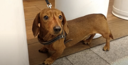

In [70]:
print("Input image:\n")
img = PILImage.create(uploader.data[-1])
img.to_thumb(128,128)

In [71]:
img = PILImage.create(uploader.data[0])
predicted_breed_id = learn.predict(img)[0]
predicted_breed = class_to_breed[predicted_breed_id]

In [72]:
print("Predicted breed:\n")
predicted_breed.name

Predicted breed:



'Dachshund'

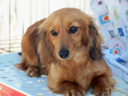

In [65]:
handler = SimpleNamespace(data=[predicted_breed.image_sample_path])
sample_img = PILImage.create(handler.data[-1])
sample_img.to_thumb(128,128)